<a href="https://colab.research.google.com/github/gedeck/mistat-code-solutions/blob/main/IndustrialStatistics/notebooks/Chap004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4
 Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
!pip install mistat --quiet

# Multivariate Statistical Process Control

In [2]:
from collections import defaultdict
import mistat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso
import seaborn as sns

## Introduction

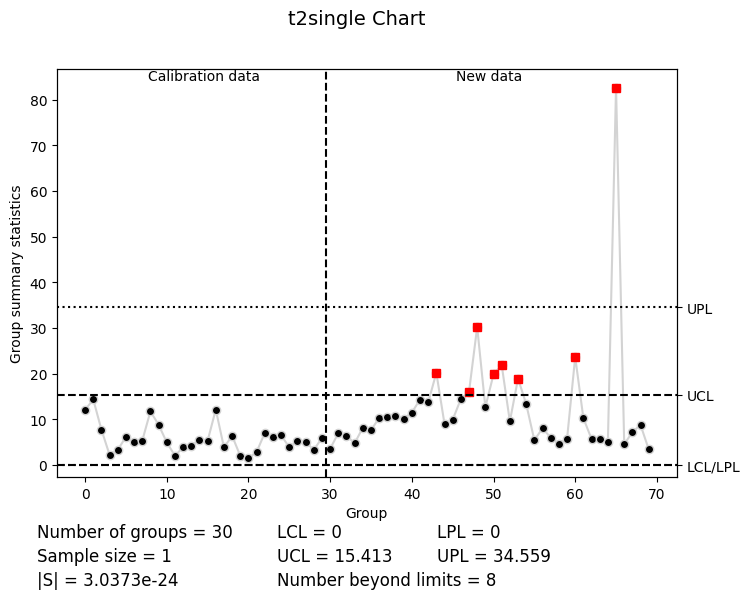

In [3]:
almpin = mistat.load_data('ALMPIN')

base = almpin.iloc[:30,]
newdata = almpin.iloc[30:,]

mqcc = mistat.MultivariateQualityControlChart(base, qcc_type='T2single',
           confidence_level=0.997, newdata=newdata)
mqcc.plot()
plt.show()

## A Review Multivariate Data Analysis

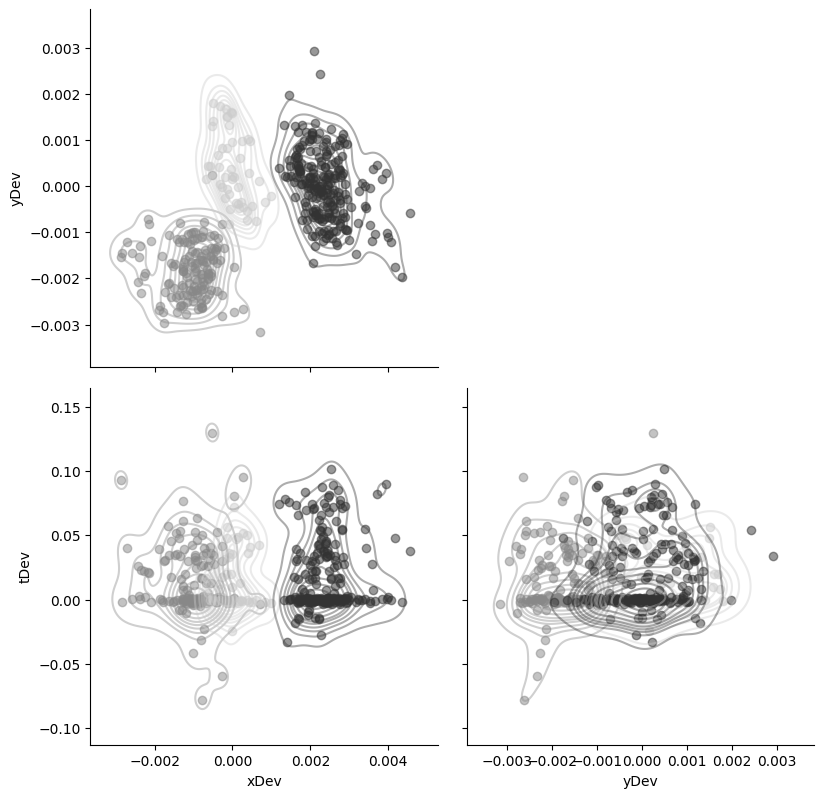

In [4]:
place = mistat.load_data('PLACE')
place['code'] = [*['lDev'] * 9 * 16, *['mDev'] * 3 * 16, *['hDev'] * 14 * 16, ]

def plotOffdiagonal(x, y, label=None, color=None):
    sns.kdeplot(x=x, y=y, color=color, alpha=0.4)
    plt.scatter(x=x, y=y, color=color, alpha=0.5)

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = sns.PairGrid(place.drop(columns=['crcBrd']), hue='code', height=4,
                palette=['#888888', '#cccccc', '#333333'])
g.map_upper(hide_current_axis)
g.map_lower(plotOffdiagonal)
for i in range(3):
    g.axes[i, i].set_visible(False)
plt.show()

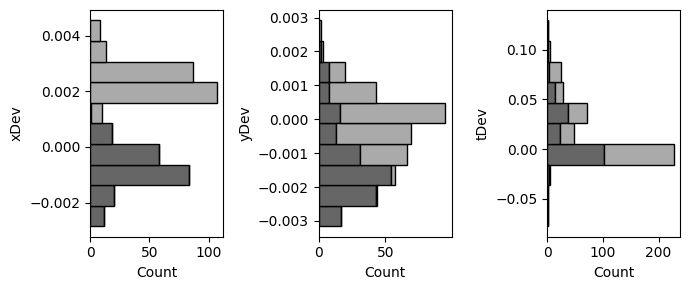

In [5]:
place = mistat.load_data('PLACE')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 3))

low = place['xDev'] < 0.001
high = place['xDev'] >= 0.001

for i, column in enumerate(['xDev', 'yDev', 'tDev']):
    axes[i].hist([place.loc[low, column], place.loc[high, column]],
                 orientation='horizontal', bins=10, stacked=True,
                 color=['#666666', '#aaaaaa'], edgecolor='black')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

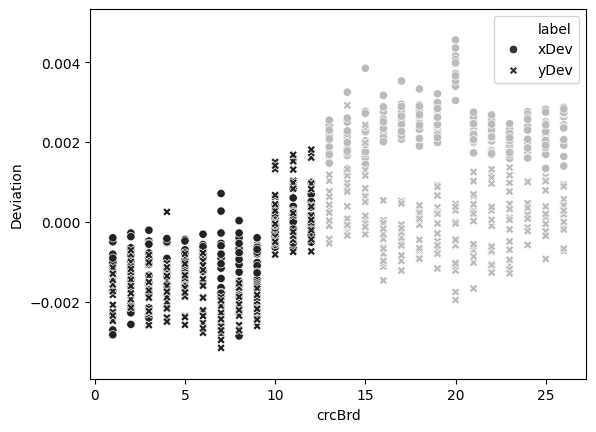

In [6]:
place = mistat.load_data('PLACE')

low = place['xDev'] < 0.001
high = place['xDev'] >= 0.001
xDev = place.copy()
xDev['Deviation'] = xDev['xDev']
xDev['label'] = 'xDev'
yDev = place.copy()
yDev['Deviation'] = yDev['yDev']
yDev['label'] = 'yDev'

place2 = pd.concat([xDev, yDev])
place2['level'] = ['low' if x < 0.001 else 'high' for x in place2['xDev']]

ax = sns.scatterplot(x="crcBrd", y="Deviation", style='label', data=place2,
                     hue='level', palette=['#222222', '#bbbbbb'], legend='full')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:])

dy = 0.1 * (max(place2['Deviation']) - min(place2['Deviation']))
ax.set_ylim(min(place2['Deviation']) - dy, max(place2['Deviation']) + dy)
plt.show()

## Multivariate Process Capability Indices

## Advanced Applications of Multivariate Control Charts

### Multivariate Control Charts Scenarios

### Internally Derived Target

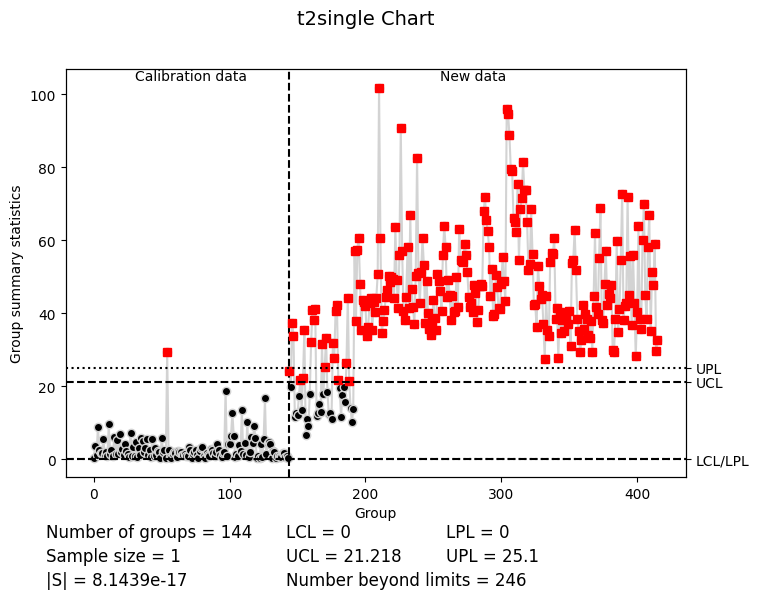

In [7]:
place = mistat.load_data('PLACE')

columns = ['xDev', 'yDev', 'tDev']
calibration = place[place.crcBrd <= 9][columns]
newdata = place[place.crcBrd > 9][columns]

mqcc = mistat.MultivariateQualityControlChart(calibration,
        qcc_type='T2single', newdata=newdata,
        confidence_level=(1-0.0000152837)**3)
mqcc.plot()
plt.show()

### External Reference Sample

### Externally Assigned Target

### Measurement Units Considered as Batches

### Variable Decomposition and Monitoring Indices

## Multivariate Tolerance Specifications

In [8]:
diss = mistat.load_data('DISS')
columns = ['batch', 'min15', 'min90']

mahalanobisT2 = mistat.MahalanobisT2(diss[columns], 'batch',
    compare_to=[15,15], conf_level=0.95)
mahalanobisT2.summary()

Coordinates
            min15     min90
LCR     14.558418 -2.810708
Center  17.541667 -3.386667
UCR     20.524915 -3.962625

Mahalanobis
LCR        8.664879
Center    10.440449
UCR       12.216019
dtype: float64

 comparison: 9.6308


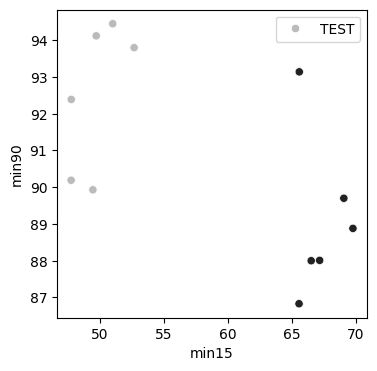

In [9]:
diss = mistat.load_data('DISS')

fig, ax = plt.subplots(figsize=[4, 4])
sns.scatterplot(x='min15', y='min90', hue='batch', data=diss,
                palette=['#222222', '#bbbbbb'], legend='brief', ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

plt.show()

In [10]:
def to_coord_rep(coord):
    return f'({coord[0]:.2f}, {coord[1]:.2f})'
center_s = to_coord_rep(mahalanobisT2.coord.loc['Center', :])
lcr_s = to_coord_rep(mahalanobisT2.coord.loc['LCR', :])
ucr_s = to_coord_rep(mahalanobisT2.coord.loc['UCR', :])

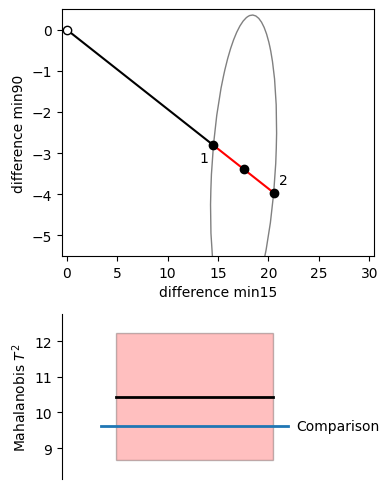

In [11]:
axes = mahalanobisT2.plot()
axes[0].set_ylim(-5.5, 0.5)
axes[0].set_xlim(-0.5, 30.5)

delta = np.array([1, 0.3])
axes[0].text(*(mahalanobisT2.coord.loc['LCR',:]-delta), '1', ha='center', va='center')
axes[0].text(*(mahalanobisT2.coord.loc['UCR',:]+delta), '2', ha='center', va='center')

plt.show()

## Tracking Structural Changes

### The Synthetic Control Method

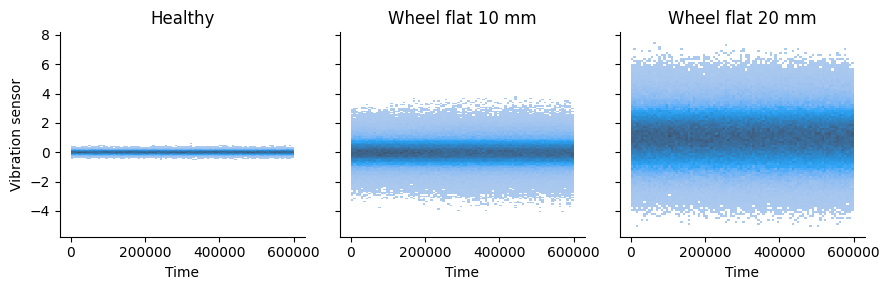

In [12]:
timeseries = mistat.load_data('SCM_TIMESERIES')
columns = ['Healthy', '10 mm', '20 mm']
index = list(range(len(timeseries['Healthy'])))
# convert from wide to long format
timeseries = pd.concat([pd.DataFrame({'index': index, 'sensor': timeseries[value], 'type': value})
                        for value in columns])

def plotTimeSeries(index, data, *args, **kwargs):
    p = sns.histplot(x=index, y=data, **kwargs)
    plt.setp(p.lines, alpha=0.5)
g = sns.FacetGrid(timeseries, col="type")
g.map(plotTimeSeries, "index", "sensor", bins=90)
axes = g.axes.flatten()
axes[0].set_title('Healthy')
axes[1].set_title('Wheel flat 10 mm')
axes[2].set_title('Wheel flat 20 mm')
g.set_axis_labels(x_var="Time", y_var="Vibration sensor")
plt.tight_layout()

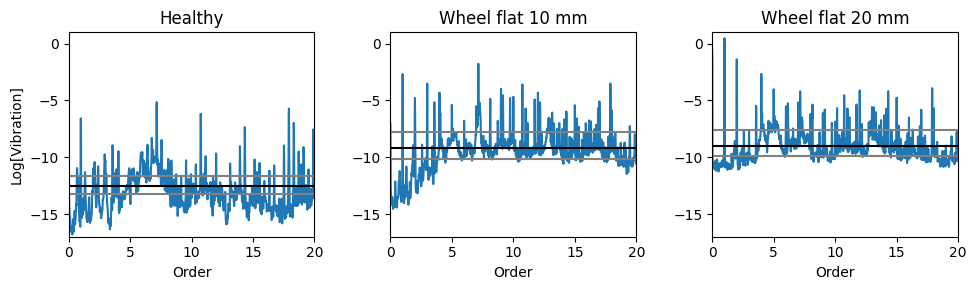

In [13]:
order_psd = mistat.load_data('ORDER_PSD')
def plotVibrations(colname, title, ax, ylabel=None):
    ydata = order_psd[colname]
    order_psd.plot(x='Order', y=colname, ax=ax, ylabel=ylabel, title=title)
    ax.set_ylim(-17, 1)
    ax.set_xlim(0, 20)
    ax.get_legend().remove()
    ax.axhline(ydata.median(), color='black')
    ax.axhline(ydata.quantile(q=0.75), color='grey')
    ax.axhline(ydata.quantile(q=0.25), color='grey')

fig, axes = plt.subplots(ncols=3, figsize=[10, 3])
plotVibrations('Log[Healthy]', 'Healthy', axes[0], ylabel='Log[Vibration]')
plotVibrations('Log[PSD - 10 mm]', 'Wheel flat 10 mm', axes[1])
plotVibrations('Log[PSD - 20 mm]', 'Wheel flat 20 mm', axes[2])

plt.tight_layout()

In [14]:
data = mistat.load_data('SCM_WHEELS.csv')
nr_wheels = 40
scm_data = defaultdict(list)
n = len(data)
for i in range(1, nr_wheels+1):
    scm_data['wheel'].extend([i] * n)
    scm_data['time'].extend(range(1, n+1))
    scm_data['vibrations'].extend(data[f'Wheel-{i}'])
    scm_data['status'].extend([True if i == 1 else False] * n)
    scm_data['after_event'].extend([False] * 59)
    scm_data['after_event'].extend([True] * 41)

scm_data = pd.DataFrame(scm_data).sort_values(by=['time', 'wheel'])

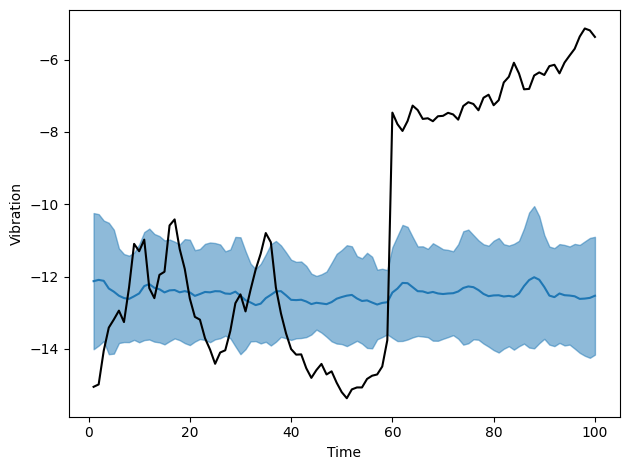

In [15]:
mean_vibrations = scm_data.groupby(['time'])['vibrations'].aggregate(['mean', 'std'])
mean_vibrations['upper'] = mean_vibrations['mean'] + mean_vibrations['std']
mean_vibrations['lower'] = mean_vibrations['mean'] - mean_vibrations['std']

fig, ax = plt.subplots()
ax.fill_between(mean_vibrations.index, mean_vibrations['upper'], mean_vibrations['lower'], color='C0', alpha=0.5)
ax.plot(mean_vibrations.index, mean_vibrations['mean'], color='C0')
scm_data.query('status').groupby('wheel').plot(x='time', y='vibrations', ax=ax, legend=None, color='black')
ax.set_ylabel('Vibration')
ax.set_xlabel('Time')

plt.tight_layout()
plt.show()

In [16]:
def train_predict_SCM_model(scm_data, wheel, event):
    # convert data into a table with vibration and sensor data in rows and
    # wheels in columns
    features = ['vibrations']
    full_data = scm_data.pivot(index='wheel', columns='time')[features].T

    # filter pre-damage event period (make a slice on the multi-index)
    pre_event = full_data.loc[('vibrations', 1):('vibrations', event)]

    # train regularized regression model
    X = pre_event.drop(columns=wheel).values  # other wheels
    y = pre_event[wheel].values # selected wheel
    model = Lasso(fit_intercept=False, max_iter=10_000, alpha=2, selection='random', random_state=1)
    model.fit(X, y)

    vibrations = full_data.loc['vibrations']
    pred_y = model.predict(vibrations.drop(columns=wheel))
    return pd.DataFrame({
        'time': scm_data.query(f'wheel == {wheel}')['time'],
        'vibrations': scm_data.query(f'wheel == {wheel}')['vibrations'],
        'synthetic': pred_y,
        'residual': scm_data.query(f'wheel == {wheel}')['vibrations'] - pred_y,
    })

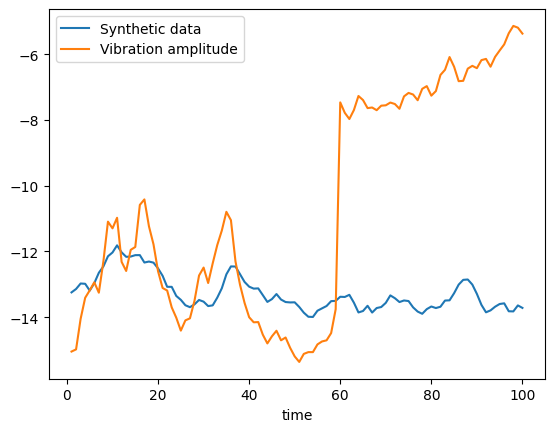

In [17]:
scm_faulty = train_predict_SCM_model(scm_data, 1, 60)
ax = scm_faulty.plot(x='time', y='synthetic', label='Synthetic data')
scm_faulty.plot(x='time', y='vibrations', label='Vibration amplitude', ax=ax)
plt.show()

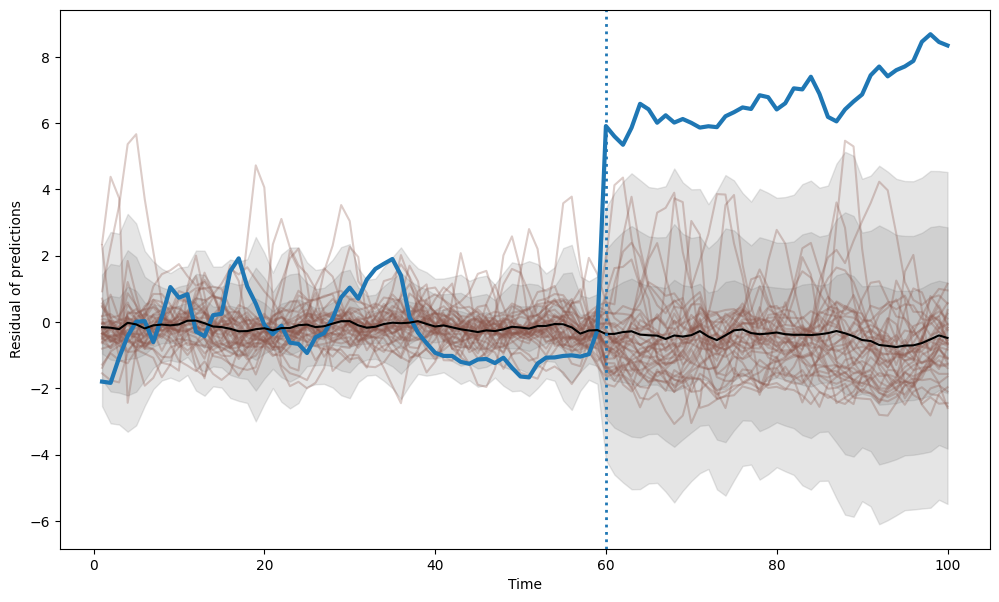

In [18]:
scm_healthy_predictions = [train_predict_SCM_model(scm_data, wheel, 60) for wheel in range(2, nr_wheels+1)]

# calculate mean and standard deviation of residuals
predictions = [scm_healthy['residual'] for scm_healthy in scm_healthy_predictions]
predictions.append(scm_faulty['residual'])
predictions = np.array(predictions)
pred_mean = predictions.mean(axis=0)
pred_std = predictions.std(axis=0)

fig, ax = plt.subplots(figsize=(12, 7))

for f in (1, 2, 3):
    ax.fill_between(scm_faulty['time'], pred_mean+f*pred_std, pred_mean-f*pred_std, color='grey', alpha=0.2)
for scm_healthy in scm_healthy_predictions:
    ax.plot(scm_healthy['time'], scm_healthy['residual'], color='C5', alpha=0.3)

ax.plot(scm_faulty['time'], scm_faulty['residual'], linewidth=3)
ax.plot(scm_faulty['time'], pred_mean, color='black')

ax.axvline(x=60, linestyle=':', lw=2, label='Wheel damage occurs')
ax.set_ylabel('Residual of predictions')
ax.set_xlabel('Time')
plt.show()

## Chapter Highlights

## Exercises